In [1]:
from IPython.core.display import HTML
css_file = '../../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# *grmpy* Package


In [2]:
# standard library
import os
import sys
import numpy as np
 
# edit PYTHONPATH
sys.path.insert(0, 'grmpy')

# project library
import grmpy as gp

This is a first look at the structure of the *grmpy* package.

Let us take a look at around the package in *PyCharm* in more detail. For example, we will study how to actually distribute a *Python* package across several files and folders. Throughout, we will encounter some very useful feature of our IDE that allow to navigate our *Python* package.


For more elaborate versions of *Python* packages I use in my research and teaching, please visit the [grmToolbox](https://github.com/grmToolbox) and the [structToolbox](https://github.com/structToolbox).

Now that we have an idea about the structure of the package, let us make some simple calls to the public functions

In [3]:
# Process initialization file
init_dict = gp.process('init.ini')

# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.41

     TT        -1.69

     TUT        0.87


 Parameters

     Start    Finish

      0.34      0.34
      0.55      0.55
      0.58      0.58
      0.52      0.52
      0.00      0.00
      0.99      0.99
      0.91      0.91
      0.21      0.21
      0.29      0.29
      0.52      0.52
      0.90      0.90
      0.98      0.98
      0.26      0.26
      0.06      0.06
      0.31      0.31


Is our code working for all the different version of the model we want to be able to estimate? Often, parts of the code are only visited in special cases which results in errors remaining undetected for quite a while. Let us just hit the package with some random requests and see if it all runs. Later, of course, we will focus on whether it is actually working correctly.

In [4]:
# project library
from tests._auxiliary import random_init

# Set the number of tests to run
NUM_TESTS = 10

# Run repeated tests
for _ in range(NUM_TESTS):

    # Generate random request
    init_dict = random_init()
    
    # Let us restrict attention to either zero or just one 
    # step of the estimator.
    init_dict['ESTIMATION']['maxiter'] = np.random.choice([0, 1])
    
    # Simulate sample
    gp.simulate(init_dict)
    
    # Estimate model
    rslt = gp.estimate(init_dict)

    # Write results
    gp.inspect(rslt, init_dict)
    

There are several implementations of the likelihood function available: slow, fast, and object. You can select the implementation to use in the initialization file. Let us make sure that the result is the same regardless of the implementation. 

In [5]:
# Set the number of tests to run
NUM_TESTS = 1

# Run repeated tests
for _ in range(NUM_TESTS):

    # Generate random request
    init_dict = random_init()

    # Ensure same starting value. If we choose the random 
    # starting values instead, the points of evaluation 
    # differ for the slow and fast implementations.
    init_dict['ESTIMATION']['start'] = 'init'

    # Simulate sample
    gp.simulate(init_dict)
    
    # Initialize result container
    rslt = dict()
    
    # Estimate generalized Roy model
    for version in ['slow', 'fast']:

        init_dict['ESTIMATION']['version'] = version

        rslt[version] = gp.estimate(init_dict)['fval']

    # Assert equality of results
    np.testing.assert_allclose(rslt['slow'], rslt['fast'])

    # Cleanup
    os.remove(init_dict['BASICS']['file'])

Let's see how the execution time differes as we increase the number of observations.

In [6]:
# standard library
import time

# Set grid for varying number of agents
agent_grid = range(1000, 10000, 500)

# Generate random request
init_dict = random_init()

# Request single function evaluation
init_dict['ESTIMATION']['maxiter'] = 0

# Simulate sample
rslt = dict()

for version in ['slow', 'fast']:
    
    # Initialzie container for results
    rslt[version] = []
    
    # Update initialization file
    init_dict['ESTIMATION']['version'] = version
    
    for agents in agent_grid:
        
        # Update initialization file
        init_dict['BASICS']['agents'] = agents
        
        # Simulate sample
        gp.simulate(init_dict)
        
        # Measure execution time of for estimation
        start_time = time.time()

        gp.estimate(init_dict)

        rslt[version] += [ time.time() - start_time]a

Now we can easily visualize the difference in performance.

Populating the interactive namespace from numpy and matplotlib


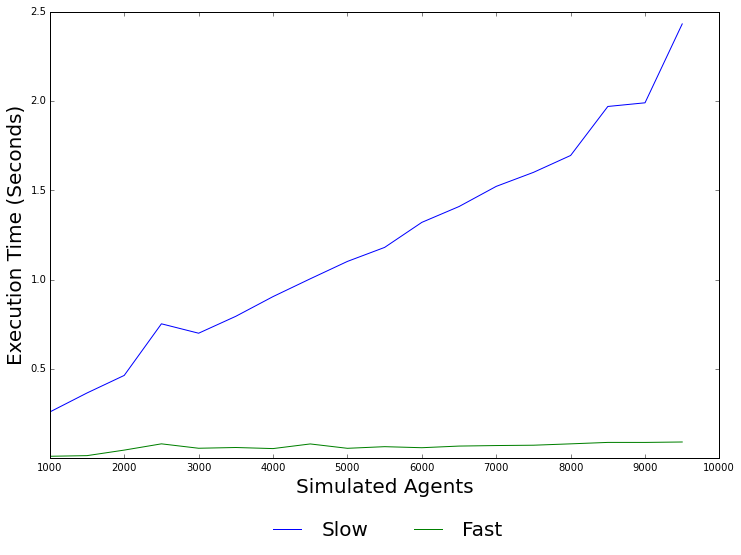

In [7]:
# standard library
import matplotlib.pyplot as plt

# Inline rendering of matplotlib graphs
%pylab inline

# Initialize canvas
ax = plt.figure(figsize=(12,8)).add_subplot(111)

# Plot execution times by implementations 
ax.plot(agent_grid, rslt['slow'], label='Slow')
ax.plot(agent_grid, rslt['fast'], label='Fast')

# Set axis labels
ax.set_xlabel('Simulated Agents', fontsize=20)
ax.set_ylabel('Execution Time (Seconds)', fontsize=20)

# Set up legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
    fancybox=False, frameon=False, shadow=False, ncol=2,
    fontsize=20)
     
# Remove first element on y-axis
ax.yaxis.get_major_ticks()[0].set_visible(False)

Now, let us finally have a look whether the program actually recovers the true structural parameters.

In [8]:
# Generate random request
init_dict = random_init()

# Let us make sure to have a setup that is very favourable to
# the performance of our estimator for now. In my experience,
# small unobserved variability in agent choices and outcomes
# and a large agent count does the trick. Of course, later 
# you would want to investigate the performance of your 
# estimator for more challenging tasks.
for key_ in ['COST', 'TREATED', 'UNTREATED']:
    init_dict[key_]['var'] = 0.02

init_dict['BASICS']['agents'] = 10000

# We need to ensure that the random request actually entails
# a serious estimation run.
init_dict['ESTIMATION']['maxiter'] = 100
init_dict['ESTIMATION']['start'] = 'random'
init_dict['ESTIMATION']['version'] = 'fast'
init_dict['ESTIMATION']['optimizer'] = 'bfgs'
    
# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Check for convergence, which is very different from our 
# notion of a SUCCESSFUL estimation run. 
assert (rslt['success'] is True)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE        0.07

     TT        -0.04

     TUT        0.16


 Parameters

     Start    Finish

      0.91      0.28
      0.96     -0.37
      0.64     -0.43
      0.91      0.35
      0.40     -0.11
      0.45     -0.35
      0.81      0.26
      0.33      0.32
      0.91      0.45
      0.45     -0.04
      0.26      0.02
      0.78      0.02
      0.03     -0.17
     -0.14      0.00


How does this compare to some of the structural parameters we used for the simulation of the dataset?

In [9]:
# Coefficients in the outcome equations
print '\nCoefficients for Outcome'
print max(rslt['TREATED']['all'] - init_dict['TREATED']['all'])
print max(rslt['UNTREATED']['all'] - init_dict['UNTREATED']['all'])

# Correlations
print '\nCorrelations'
print rslt['RHO']['treated'] - init_dict['RHO']['treated']
print rslt['RHO']['untreated'] - init_dict['RHO']['untreated']



Coefficients for Outcome
0.00223507903712
-0.00052775889547

Correlations
0.003496404213
-0.0257569332138


Let us repeat this exercise, but use the Nelder Mead algorithm instead of BFGS. How does performance differ? What about using different starting values?

This concludes this lecture and all that remains done it to clean up.

In [10]:
# standard library
import glob

# Create list of all files that have the file extension `.txt'.
files = glob.glob('*.txt')

# Remove files
for file_ in files:
    
    os.remove(file_)